In [1]:
from EmbedSeg.utils.create_dicts import create_test_configs_dict
from EmbedSeg.test import begin_evaluating
from glob import glob
import tifffile
import matplotlib.pyplot as plt
from EmbedSeg.utils.visualize import visualize_3d
import os
from matplotlib.colors import ListedColormap
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import json
import tifffile
import numpy as np
import torch

### Specify the path to the evaluation images

In [2]:
data_dir = '../../../data'
project_name = 'Platynereis-ISH-Nuclei-CBG'
print("Evaluation images shall be read from: {}".format(os.path.join(data_dir, project_name)))

Evaluation images shall be read from: ../../../data/Platynereis-ISH-Nuclei-CBG


### Specify evaluation parameters 

Some hints:
* `tta`: Setting this to True (default) would enable **test-time augmentation**
* `ap_val`: This parameter ("average precision value") comes into action if ground truth segmentations exist for evaluation images, and allows to compare how good our predictions are versus the available ground truth segmentations.
* `checkpoint_path`: This parameter provides the path to the trained model weights which you would like to use for evaluation. One could test the pretrained model (available at `'../../../pretrained_models/Platynereis-Nuclei-CBG/best_iou_model.pth'`) to get a quick glimpse on the results.
* `save_dir`: This parameter specifies the path to the prediction instances. Equal to `inference` by default.

In the cell after this one, a `test_configs` dictionary is generated from the parameters specified here!
<a id='checkpoint'></a>

In [3]:
# uncomment for the model trained by you
# checkpoint_path = os.path.join('experiment', project_name+'-'+'demo', 'best_iou_model.pth')
# if os.path.isfile('data_properties.json'): 
#     with open('data_properties.json') as json_file:
#         data = json.load(json_file)
#         one_hot = data['one_hot']
#         data_type = data['data_type']
#         min_object_size = int(data['min_object_size'])
#         foreground_weight = float(data['foreground_weight'])
#         n_z, n_y, n_x = int(data['n_z']),int(data['n_y']), int(data['n_x'])
#         pixel_size_z_microns, pixel_size_y_microns, pixel_size_x_microns = float(data['pixel_size_z_microns']), float(data['pixel_size_y_microns']), float(data['pixel_size_x_microns']) 
# if os.path.isfile('normalization.json'): 
#     with open(os.path.join('normalization.json') as json_file:
#         data = json.load(json_file)
#         norm = data['norm']



# use the following for the pretrained model weights
torch.hub.download_url_to_file(url = 'https://owncloud.mpi-cbg.de/index.php/s/VcbsSzVexUPgcZD/download', 
                               dst = 'pretrained_model', progress=True)
import zipfile
with zipfile.ZipFile('pretrained_model', 'r') as zip_ref:
    zip_ref.extractall('')
checkpoint_path = os.path.join(project_name+'-'+'demo', 'best_iou_model.pth')
if os.path.isfile(os.path.join(project_name+'-'+'demo','data_properties.json')): 
    with open(os.path.join(project_name+'-'+'demo', 'data_properties.json')) as json_file:
        data = json.load(json_file)
        data_type = data['data_type']
        min_object_size = int(data['min_object_size']) 
        n_z, n_y, n_x = int(data['n_z']), int(data['n_y']), int(data['n_x'])
        pixel_size_z_microns, pixel_size_y_microns, pixel_size_x_microns = float(data['pixel_size_z_microns']), float(data['pixel_size_y_microns']), float(data['pixel_size_x_microns']) 

if os.path.isfile(os.path.join(project_name+'-'+'demo','normalization.json')): 
    with open(os.path.join(project_name+'-'+'demo', 'normalization.json')) as json_file:
        data = json.load(json_file)
        norm = data['norm']

0.00B [00:00, ?B/s]

ℹ️ Setting `tta=True` would give better results but would take longer to compute!

In [4]:
tta = True
ap_val = 0.5
save_dir = './inference'

In [5]:
if os.path.exists(checkpoint_path):
    print("Trained model weights found at : {}".format(checkpoint_path))
else:
    print("Trained model weights were not found at the specified location!")

Trained model weights found at : Platynereis-ISH-Nuclei-CBG-demo/best_iou_model.pth


### Create `test_configs` dictionary from the above-specified parameters

In [6]:
test_configs = create_test_configs_dict(data_dir = os.path.join(data_dir, project_name),
                                        checkpoint_path = checkpoint_path,
                                        tta = tta, 
                                        ap_val = ap_val,
                                        min_object_size = min_object_size, 
                                        save_dir = save_dir,
                                        norm = norm, 
                                        data_type = data_type,
                                        n_z = n_z,
                                        n_y = n_y,
                                        n_x = n_x,
                                        anisotropy_factor = pixel_size_z_microns/pixel_size_x_microns,
                                        name = '3d',
                                        )

`test_configs` dictionary successfully created with: 
 -- evaluation images accessed from ../../../data/Platynereis-ISH-Nuclei-CBG, 
 -- trained weights accessed from Platynereis-ISH-Nuclei-CBG-demo/best_iou_model.pth, 
 -- output directory chosen as ./inference


### Begin Evaluating

The higher the Average Precision ($AP_{dsb}$) score is, the better the network has learnt to perform instance segmentation on these unseen images.

In [7]:
begin_evaluating(test_configs)

3-D `test` dataloader created! Accessing data from ../../../data/Platynereis-ISH-Nuclei-CBG/test/
Number of images in `test` directory is 1
Number of instances in `test` directory is 1
Number of center images in `test` directory is 0
*************************
Creating Branched Erfnet 3D with [6, 1] outputs


100%|████████████████████████████████████████████| 1/1 [13:52<00:00, 832.72s/it]

Mean Average Precision (AP_dsb) at IOU threshold = 0.5 at seediness threshold = 0.90000, is equal to 0.78261


{'fg_thresh': 0.5, 'AP_dsb_05': 0.782608695652174}

<div class="alert alert-block alert-warning"> 
  Common causes for an error is: <br>
    1. Accessing the model weights at the wrong location. Simply editing the <b> checkpoint_path</b> would fix the issue. <br>
    2. CUDA error: out of memory - ensure that you shutdown <i>02-train.ipynb</i> notebook before running this notebook. <br>
    3. No test images available
</div>

### Visualize some predictions

Here you can investigate some quantitative predictions. GT segmentations and predictions, if they exist, are loaded from sub-directories under `save_dir`.
Simply change `index` to show the prediction for a random index.
Going top-bottom is 

    * the raw-image which needs to be segmented, 
    * the corresponding ground truth instance mask, 
    * the network predicted instance mask, and 
    * the confidence map predicted by the model

In [11]:
prediction_file_names = sorted(glob(os.path.join(save_dir,'predictions','*.tif')))
ground_truth_file_names = sorted(glob(os.path.join(save_dir,'ground-truth','*.tif')))
image_file_names = sorted(glob(os.path.join(data_dir, project_name, 'test', 'images','*.tif')))
seed_file_names = sorted(glob(os.path.join(save_dir, 'seeds','*.tif')))

In [12]:
new_cmp= np.load('../../../cmaps/cmap_60.npy')
new_cmp = ListedColormap(new_cmp)

Image filename is X02_test.tif and index is 0


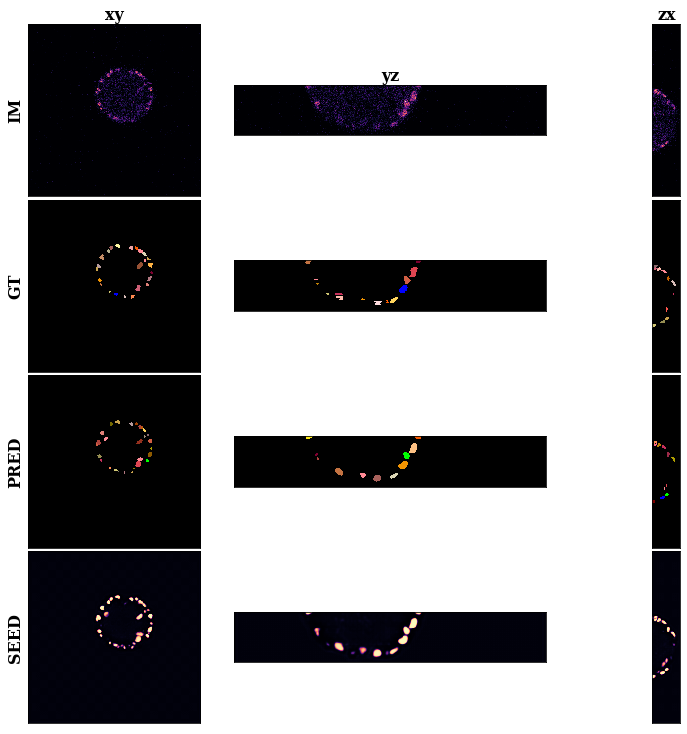

In [13]:
index = 0
print("Image filename is {} and index is {}".format(os.path.basename(image_file_names[index]), index))

visualize_3d(image_file_names[index], ground_truth_file_names[index], prediction_file_names[index], seed_file_names[index], new_cmp, anisotropy=pixel_size_z_microns/pixel_size_x_microns)
